In [74]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMRegressor
# class sklearn.model_selection.StratifiedKFold(n_splits=5,
#     shuffle=False, random_state=None)
from typing import Union, Tuple
import warnings
import numpy as np
import scipy.stats as stats
warnings.simplefilter('ignore')
warnings.simplefilter('ignore')

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/data_for_revise/prediction/brand_classification/データセット完成目的変数全て入っている.csv')
df

,県,エリア,サロン名,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,コメントへの返信率,駅徒歩,イルミナメニュー化の有無,Aujuaメニュー化の有無,addicthyメニュー化の有無,inoaメニュー化の有無
0,島根,松江,Rote【ロテ】,18,237,179,7,24,41,48,0.983,5.0,0,0,0,0
1,島根,松江,freedom belinda 松江学園店 【フリーダム ベリンダ】,10,15,161,8,34,42,5,0.130,NaN,0,0,1,0
2,島根,松江,SMITH AVEDA,10,97,209,5,15,24,23,0.981,NaN,0,0,0,0
3,島根,松江,freedom rita【フリーダム リタ】,4,0,63,3,29,37,0,0.000,NaN,0,0,0,0
4,島根,松江,lamiell matsue 【ラミールマツエ】,8,104,340,8,30,26,44,0.767,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,Chill hair,1,0,50,1,0,16,0,0.000,NaN,0,0,0,0
4075,福山・尾道,福山駅前・三吉周辺,SOYU headspa by Palm 【ソユ】,2,0,33,2,0,23,0,0.970,NaN,0,0,0,0
4076,福山・尾道,福山駅前・三吉周辺,Triangle,4,0,3,1,0,43,0,1.000,NaN,0,0,0,0
4077,福山・尾道,福山駅前・三吉周辺,Calin【カラン】,1,0,43,1,0,12,0,0.721,NaN,0,0,0,0


In [4]:
# 連続値の層化抽出クラスの定義
class ContinuousStratifiedKFold:
    def __init__(self, n_split: int=5, shuffle: bool=True, random_state: int=42) -> None:
        self.n_split = n_split
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X: pd.DataFrame, reference: pd.Series, bins: int=10,
                      suffle: Union[bool]=None, random_state: Union[int]=None) -> Tuple[np.ndarray, np.ndarray]:

        shuffle = shuffle if suffle is not None else self.shuffle
        random_state = random_state if random_state is not None else self.random_state
        min_ref, max_ref = int(reference.min() - 1), int(reference.max() + 1)
        cut_threshold = np.linspace(min_ref, max_ref, bins)
        out = pd.cut(reference, bins=cut_threshold, labels=False)

        skf = StratifiedKFold(self.n_split, shuffle=shuffle, random_state=random_state)
        for train_idx, val_idx in skf.split(X, out):
            yield train_idx, val_idx

# イルミナメニュー化の有無 のグリッドサーチ

In [9]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [10]:
prediction_column = 'イルミナメニュー化の有無'

In [11]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,イルミナメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [14]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [19]:
param_grid={
    "learning_rate":[0.001, 0.01, 0.1],
    "random_seed":[0],
    "num_leaves":[50, 100, 200, 300, 400],
    # "num_iteration":[400, 500,600, 700, 1000],
    # "n_estimators": [10000],num_iterationsと同じ
    "max_depth":[60, 100, 200, 300],
    # "min_data_in_leaf":[1,3,5,10,20,25]
    # "n_estimators": [600,1000],# n_estimatorsを入れると遅くなる。
}

In [22]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, f1_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs_scores = []
best_models = []
best_params = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
f1_scores = []
precision_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    cat_list=['県', 'エリア']
    
    model = LGBMClassifier(categorical_feature = cat_list)
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_grid, 
                      cv=KFold(n_splits=5, shuffle=True, random_state=0), 
                      n_jobs=-1,
                      scoring='f1'
                      )
    
    gs.fit(X=X_train,
           y=y_train,
           )
    gs_score = gs.best_score_
    gs_scores.append(gs_score)
    # 最適モデルの定義
    best_model = gs.best_estimator_
    best_models.append(best_model)

    best_param = gs.best_params_
    best_params.append(best_param)
    
    y_pred = best_model.predict(X_valid)
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    # 教師データ（観測値）
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    precision_scores.append(precision)
    f1_scores.append(f1)
    

5it [00:32,  6.59s/it]


In [94]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["Gridserach_score(f1)", "model", "best_params", "f1_score", "presiodion"]])
df_result["Gridserach_score(f1)"] = gs_scores
df_result["model"] = best_models
df_result["best_params"] = best_params
df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores


# 結果をcsvファイルに書き出す
df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,Gridserach_score(f1),model,best_params,f1_score,presiodion
0,0.232770,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.285714,0.606061
1,0.256938,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.283582,0.703704
2,0.277918,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.250000,0.486486
3,0.286103,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.291391,0.500000
4,0.277215,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.188406,0.406250


In [25]:
best_models[0]

LGBMClassifier(categorical_feature=['県', 'エリア'], max_depth=60, num_leaves=50,
               random_seed=0)

/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/masudaniwab

0.0 1.0 1.0


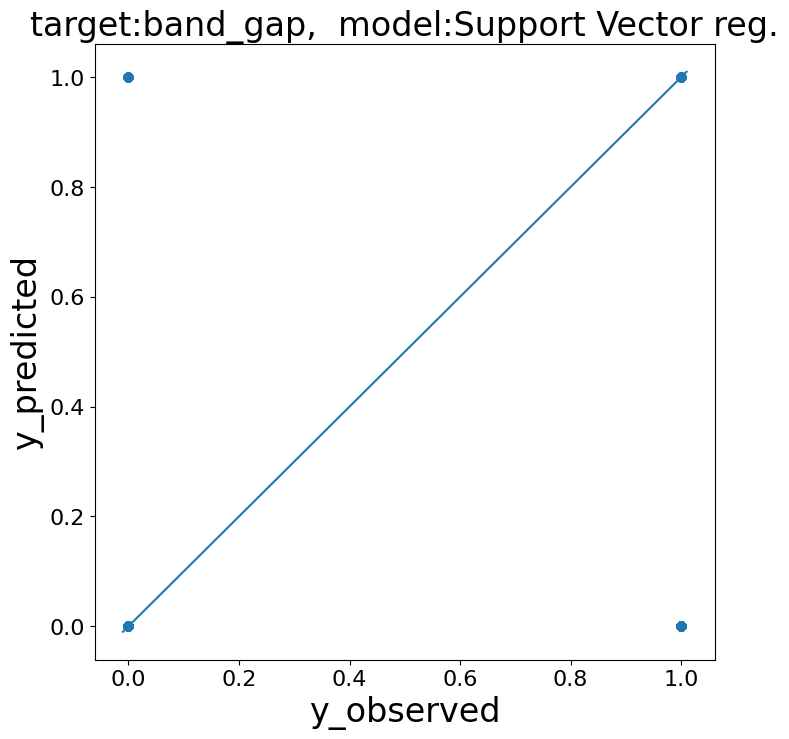

決定係数：-0.127
RMSE：0.36


In [26]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [89]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

3224    1
Name: イルミナメニュー化の有無, dtype: int64

In [90]:
_scores=[]
for model in best_models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([1]), array([1]), array([1]), array([0]), array([1])]
1


In [91]:
print((_score_mode), float(tmp_df_y))

1 1.0


In [92]:
_scores=[]
for model in best_models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([0.8441745]), array([0.80183671]), array([0.81498012]), array([0.11363189]), array([0.95718969])]


In [93]:
print(round(_score,2), float(tmp_df_y))

0.71 1.0


# 'Aujuaメニュー化の有無'のグリッドサーチ

In [95]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [96]:
prediction_column = 'Aujuaメニュー化の有無'

In [97]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,Aujuaメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,0
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [98]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [99]:
param_grid={
    "learning_rate":[0.001, 0.01, 0.1],
    "random_seed":[0],
    "num_leaves":[50, 100, 200, 300, 400],
    # "num_iteration":[400, 500,600, 700, 1000],
    # "n_estimators": [10000],num_iterationsと同じ
    "max_depth":[60, 100, 200, 300],
    # "min_data_in_leaf":[1,3,5,10,20,25]
    # "n_estimators": [600,1000],# n_estimatorsを入れると遅くなる。
}

In [100]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, f1_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs_scores = []
best_models = []
best_params = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
f1_scores = []
precision_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    cat_list=['県', 'エリア']
    
    model = LGBMClassifier(categorical_feature = cat_list)
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_grid, 
                      cv=KFold(n_splits=5, shuffle=True, random_state=0), 
                      n_jobs=-1,
                      scoring='f1'
                      )
    
    gs.fit(X=X_train,
           y=y_train,
           )
    gs_score = gs.best_score_
    gs_scores.append(gs_score)
    # 最適モデルの定義
    best_model = gs.best_estimator_
    best_models.append(best_model)

    best_param = gs.best_params_
    best_params.append(best_param)
    
    y_pred = best_model.predict(X_valid)
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    # 教師データ（観測値）
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    precision_scores.append(precision)
    f1_scores.append(f1)
    

5it [00:34,  6.94s/it]


In [101]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["Gridserach_score(f1)", "model", "best_params", "f1_score", "presiodion"]])
df_result["Gridserach_score(f1)"] = gs_scores
df_result["model"] = best_models
df_result["best_params"] = best_params
df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores


# 結果をcsvファイルに書き出す
df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,Gridserach_score(f1),model,best_params,f1_score,presiodion
0,0.169320,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.137931,0.400000
1,0.172390,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.169492,0.454545
2,0.123373,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.237288,0.700000
3,0.119037,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.169492,0.500000
4,0.130456,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.107143,0.375000


In [102]:
best_models[0]

LGBMClassifier(categorical_feature=['県', 'エリア'], max_depth=60, num_leaves=200,
               random_seed=0)

0.0 1.0 1.0


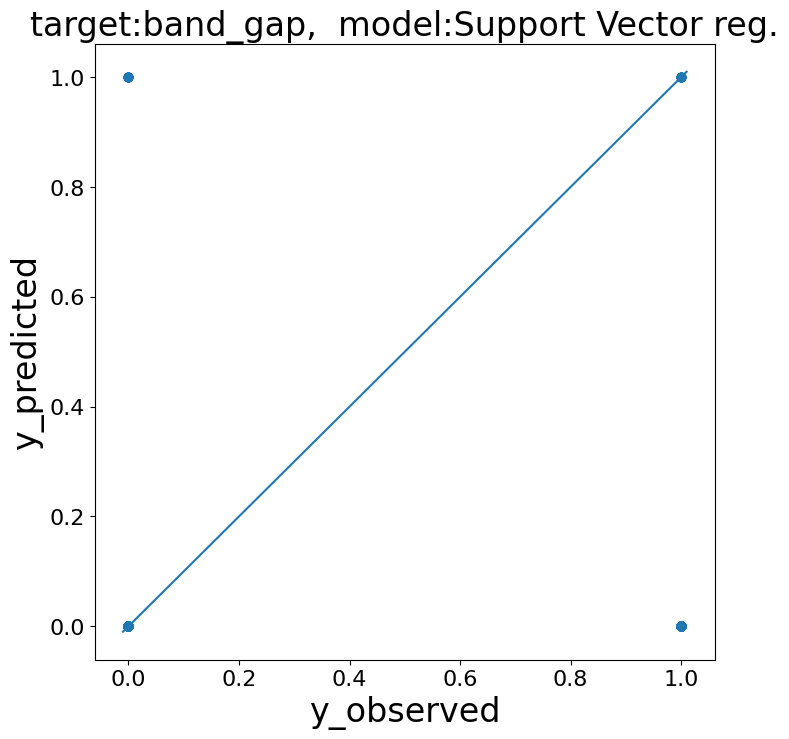

決定係数：-0.067
RMSE：0.24


In [103]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [104]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

823    0
Name: Aujuaメニュー化の有無, dtype: int64

In [105]:
_scores=[]
for model in best_models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([0]), array([0]), array([0]), array([0]), array([0])]
0


In [106]:
print((_score_mode), float(tmp_df_y))

0 0.0


In [107]:
_scores=[]
for model in best_models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([8.87064397e-06]), array([1.0065285e-05]), array([5.3665947e-06]), array([5.84295659e-06]), array([6.4395015e-06])]


In [114]:
print(round(_score,2), float(tmp_df_y))

0.0 0.0


# ''addicthyメニュー化の有無'のグリッドサーチ

In [115]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [116]:
prediction_column = 'addicthyメニュー化の有無'

In [117]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,addicthyメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,1
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [118]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [119]:
param_grid={
    "learning_rate":[0.001, 0.01, 0.1],
    "random_seed":[0],
    "num_leaves":[50, 100, 200, 300, 400],
    # "num_iteration":[400, 500,600, 700, 1000],
    # "n_estimators": [10000],num_iterationsと同じ
    "max_depth":[60, 100, 200, 300],
    # "min_data_in_leaf":[1,3,5,10,20,25]
    # "n_estimators": [600,1000],# n_estimatorsを入れると遅くなる。
}

In [120]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, f1_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs_scores = []
best_models = []
best_params = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
f1_scores = []
precision_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    cat_list=['県', 'エリア']
    
    model = LGBMClassifier(categorical_feature = cat_list)
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_grid, 
                      cv=KFold(n_splits=5, shuffle=True, random_state=0), 
                      n_jobs=-1,
                      scoring='f1'
                      )
    
    gs.fit(X=X_train,
           y=y_train,
           )
    gs_score = gs.best_score_
    gs_scores.append(gs_score)
    # 最適モデルの定義
    best_model = gs.best_estimator_
    best_models.append(best_model)

    best_param = gs.best_params_
    best_params.append(best_param)
    
    y_pred = best_model.predict(X_valid)
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    # 教師データ（観測値）
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    precision_scores.append(precision)
    f1_scores.append(f1)
    

1it [00:06,  6.06s/it]/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.

In [121]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["Gridserach_score(f1)", "model", "best_params", "f1_score", "presiodion"]])
df_result["Gridserach_score(f1)"] = gs_scores
df_result["model"] = best_models
df_result["best_params"] = best_params
df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores


# 結果をcsvファイルに書き出す
df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,Gridserach_score(f1),model,best_params,f1_score,presiodion
0,0.406693,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.301370,0.687500
1,0.341896,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.395062,0.695652
2,0.362993,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.395062,0.695652
3,0.413570,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.315789,0.666667
4,0.394870,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.375000,0.652174


In [122]:
best_models[0]

LGBMClassifier(categorical_feature=['県', 'エリア'], max_depth=60, num_leaves=200,
               random_seed=0)

0.0 1.0 1.0


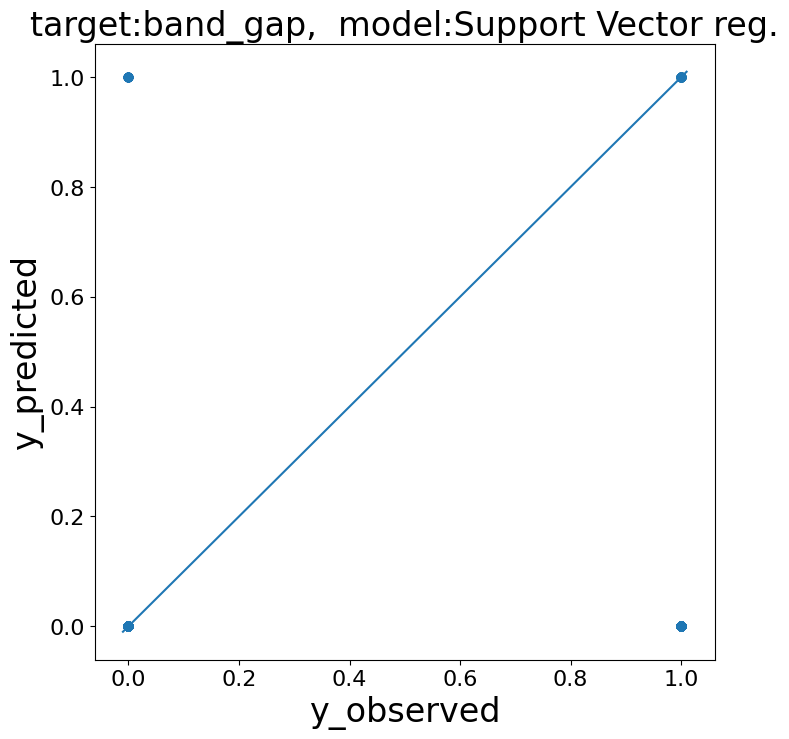

決定係数：0.062
RMSE：0.25


In [123]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [124]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

1541    0
Name: addicthyメニュー化の有無, dtype: int64

In [125]:
_scores=[]
for model in best_models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([0]), array([0]), array([0]), array([0]), array([0])]
0


In [126]:
print((_score_mode), float(tmp_df_y))

0 0.0


In [127]:
_scores=[]
for model in best_models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([9.43462021e-05]), array([3.10564109e-05]), array([1.18414204e-05]), array([2.83251691e-05]), array([0.0002788])]


In [128]:
print(round(_score,2), float(tmp_df_y))

0.0 0.0


# 'inoaメニュー化の有無'のグリッドサーチ

In [129]:
df.columns

Index(['県', 'エリア', 'サロン名', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', 'コメントへの返信率', '駅徒歩', 'イルミナメニュー化の有無', 'Aujuaメニュー化の有無',
       'addicthyメニュー化の有無', 'inoaメニュー化の有無'],
      dtype='object')

In [130]:
prediction_column = 'addicthyメニュー化の有無'

In [131]:
_df = df.copy()
_df=_df[['県', 'エリア', 'セット面の数', 'ブログ投稿数', '口コミ数', 'スタッフ数', 'クーポン数',
       'メニュー数', 'スタイル数', '駅徒歩', 'コメントへの返信率', prediction_column]]
# _df=_df[_df[prediction_column]!=0.0].reset_index(drop=True)
display(_df)

,県,エリア,セット面の数,ブログ投稿数,口コミ数,スタッフ数,クーポン数,メニュー数,スタイル数,駅徒歩,コメントへの返信率,addicthyメニュー化の有無
0,島根,松江,18,237,179,7,24,41,48,5.0,0.983,0
1,島根,松江,10,15,161,8,34,42,5,NaN,0.130,1
2,島根,松江,10,97,209,5,15,24,23,NaN,0.981,0
3,島根,松江,4,0,63,3,29,37,0,NaN,0.000,0
4,島根,松江,8,104,340,8,30,26,44,NaN,0.767,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4074,福山・尾道,福山駅前・三吉周辺,1,0,50,1,0,16,0,NaN,0.000,0
4075,福山・尾道,福山駅前・三吉周辺,2,0,33,2,0,23,0,NaN,0.970,0
4076,福山・尾道,福山駅前・三吉周辺,4,0,3,1,0,43,0,NaN,1.000,0
4077,福山・尾道,福山駅前・三吉周辺,1,0,43,1,0,12,0,NaN,0.721,0


In [132]:
_df_X = _df.drop(prediction_column, axis=1).reset_index(drop=True)
_df_y = _df[prediction_column].reset_index(drop=True)
_df_X['県'] = _df_X['県'].astype('category')
_df_X['エリア'] = _df_X['エリア'].astype('category')

In [133]:
param_grid={
    "learning_rate":[0.001, 0.01, 0.1],
    "random_seed":[0],
    "num_leaves":[50, 100, 200, 300, 400],
    # "num_iteration":[400, 500,600, 700, 1000],
    # "n_estimators": [10000],num_iterationsと同じ
    "max_depth":[60, 100, 200, 300],
    # "min_data_in_leaf":[1,3,5,10,20,25]
    # "n_estimators": [600,1000],# n_estimatorsを入れると遅くなる。
}

In [134]:
from tqdm import tqdm
from lightgbm.callback import early_stopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, f1_score
SKF = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

gs_scores = []
best_models = []
best_params = []
df_y_preds = pd.DataFrame()
df_y_observes = pd.DataFrame()
f1_scores = []
precision_scores = []

for train_index, valid_index in tqdm(SKF.split(X=_df_X, y=_df_y)):
    X_train = _df_X.loc[train_index, :]
    y_train = _df_y[train_index]
    X_valid = _df_X.loc[valid_index, :]
    y_valid = _df_y[valid_index]
    
    cat_list=['県', 'エリア']
    
    model = LGBMClassifier(categorical_feature = cat_list)
    gs = GridSearchCV(estimator=model, 
                      param_grid=param_grid, 
                      cv=KFold(n_splits=5, shuffle=True, random_state=0), 
                      n_jobs=-1,
                      scoring='f1'
                      )
    
    gs.fit(X=X_train,
           y=y_train,
           )
    gs_score = gs.best_score_
    gs_scores.append(gs_score)
    # 最適モデルの定義
    best_model = gs.best_estimator_
    best_models.append(best_model)

    best_param = gs.best_params_
    best_params.append(best_param)
    
    y_pred = best_model.predict(X_valid)
    df_y_preds = pd.concat([df_y_preds, pd.DataFrame(y_pred)])
    # 教師データ（観測値）
    df_y_observes = pd.concat([df_y_observes, y_valid])

    # 適合率とF1スコアの計算
    precision = precision_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)
    
    precision_scores.append(precision)
    f1_scores.append(f1)
    

1it [00:06,  6.51s/it]/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/masudaniwabinari/Desktop/HPB_analysis_dashboard/.env/lib/python3.8/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.

In [135]:
# 結果をまとめておく
import datetime

df_result = pd.DataFrame(columns=[["Gridserach_score(f1)", "model", "best_params", "f1_score", "presiodion"]])
df_result["Gridserach_score(f1)"] = gs_scores
df_result["model"] = best_models
df_result["best_params"] = best_params
df_result["f1_score"] = f1_scores
df_result["presiodion"] = precision_scores


# 結果をcsvファイルに書き出す
df_result.to_csv(f"wcv_result_targetVariable:{prediction_column}_{datetime.datetime.today()}.csv", index=False)
# データフレームで結果の表示
df_result
display(df_result)

,Gridserach_score(f1),model,best_params,f1_score,presiodion
0,0.406693,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.301370,0.687500
1,0.341896,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.395062,0.695652
2,0.362993,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.395062,0.695652
3,0.413570,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.315789,0.666667
4,0.394870,"LGBMClassifier(categorical_feature=['県', 'エリア'...","{'learning_rate': 0.1, 'max_depth': 60, 'num_l...",0.375000,0.652174


In [136]:
best_models[0]

LGBMClassifier(categorical_feature=['県', 'エリア'], max_depth=60, num_leaves=200,
               random_seed=0)

0.0 1.0 1.0


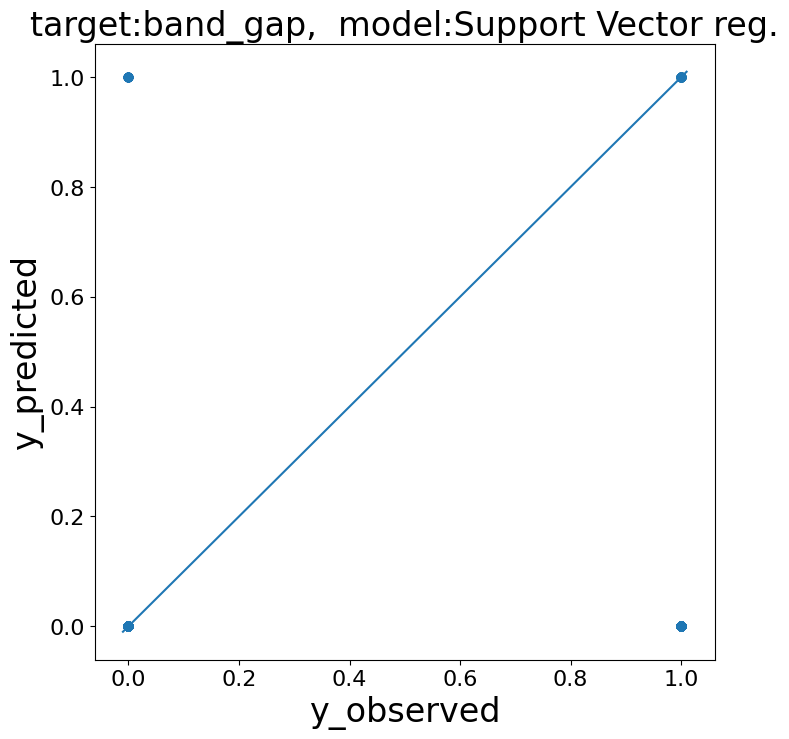

決定係数：0.062
RMSE：0.25


In [137]:
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# グラフのラベルを定義
graph_title = "target:band_gap,  model:Support Vector reg."

# yyplot 作成関数
def yyplot(y_obs, y_pred):
    yvalues = np.concatenate([y_obs.flatten(), y_pred.flatten()])
    ymin, ymax, yrange = np.amin(yvalues), np.amax(yvalues), np.ptp(yvalues)
    print(ymin, ymax, yrange)
    fig = plt.figure(figsize=(8, 8))
    plt.scatter(y_obs, y_pred)
    plt.plot([ymin - yrange * 0.01, ymax + yrange * 0.01], [ymin - yrange * 0.01, ymax + yrange * 0.01])
    # plt.xlim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    # plt.ylim(ymin - yrange * 0.01, ymax + yrange * 0.01)
    plt.xlabel('y_observed', fontsize=24)
    plt.ylabel('y_predicted', fontsize=24)
    plt.title(graph_title, fontsize=24)
    plt.tick_params(labelsize=16)
    plt.show()

    return fig

# yyplot の実行例
np.random.seed(0)
y_obs = np.random.normal(size=(1000, 1))
y_pred = y_obs + np.random.normal(scale=0.3, size=(1000, 1))
# dataframe→numpy配列にするために.valuesを実行
fig = yyplot(df_y_observes.values, df_y_preds.values)

# 決定係数の算出
r2 = r2_score(df_y_observes.values, df_y_preds.values)
print("決定係数：" + '{:.3f}'.format(r2))

# RMSEの算出
mse = mean_squared_error(y_true=df_y_observes.values, y_pred=df_y_preds.values)
print("RMSE：" + '{:.2f}'.format(np.sqrt(mse)))

In [279]:
import random
tmp_index = random.randint(1, 3900)

tmp_df_X = _df.iloc[tmp_index:tmp_index+1, :-1]
tmp_df_y = _df.iloc[tmp_index:tmp_index+1, -1]
display(tmp_df_y)
tmp_df_X['県'] = tmp_df_X['県'].astype('category')
tmp_df_X['エリア'] = tmp_df_X['エリア'].astype('category')

3157    0
Name: addicthyメニュー化の有無, dtype: int64

In [284]:
_scores=[]
for model in best_models:
    _scores.append(model.predict(tmp_df_X))
print(_scores)
_score_mode = int(stats.mode(_scores).mode)
print(_score_mode)

[array([0]), array([0]), array([0]), array([0]), array([0])]
0


In [275]:
print((_score_mode), float(tmp_df_y))

0 0.0


In [276]:
_scores=[]
for model in best_models:
    _scores.append(model.predict_proba(tmp_df_X)[:, 1])

print(_scores)

if _score_mode == 1:
    _score=np.mean(_scores)
else:
    _score=np.max(_scores)

[array([0.00022775]), array([0.00017119]), array([0.00134345]), array([0.00011847]), array([0.00239462])]


In [277]:
print(round(_score*100,2), float(tmp_df_y))

0.24 0.0
